# <b>Fondamenti di Analisi Dati</b> - a.a. 2020/2021

# 17 Dataset balancing

I dataset con classi sbilanciate rappresentano uno dei problemi più frequenti nell'analisi dati. La presenza di una classe molto sbilanciata distorce il processo di training portando il modello a focalizzarsi sulla classe maggioritaria ignorando le osservazioni più rare. Un classificatore allenato su dati sbilanciati spesso mantiene un'accuracy alta ma ottiene performance molto scadenti sulla classe minoritaria (con score molto bassi o nulli di Recall).

Per gestire un dataset con classi sbilanciate esistono diverse tecniche come l'<b>undersampling</b> (sottocampionamento) e l'<b>oversampling</b> (sovracampionamento, replicando i record o generando <b>dati sintetici</b>). Questi metodi sono utili per bilanciare il dataset prima di allenare un classificatore.

<img src="under_over_sampling.png" width="800">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

seed=123

In [2]:
df = pd.read_csv("creditcard.csv") #https://www.kaggle.com/mlg-ulb/creditcardfraud
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [3]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Seleziono alcune colonne per semplificare il dataset (a scopo di esempio).

In [4]:
df = df[['V1', 'V2', 'V3', 'Amount', 'Class']]

In [5]:
print(df.shape)
df.head()

(284807, 5)


,V1,V2,V3,Amount,Class
0,-1.359807,-0.072781,2.536347,149.62,0
1,1.191857,0.266151,0.166480,2.69,0
2,-1.358354,-1.340163,1.773209,378.66,0
3,-0.966272,-0.185226,1.792993,123.50,0
4,-1.158233,0.877737,1.548718,69.99,0


Conto i record per classe.

In [7]:
print(df.Class.value_counts())

0    284315
1       492
Name: Class, dtype: int64


Il dataset è chiaramente sbilanciato.

Per semplificare le operazioni creo un dataset con un numero ristretto di record:

In [8]:
cc = df[df.Class==1].copy() #creo un dataset con tutti i dati della classe 1
cc= cc.append(df[df.Class==0].sample(n=50000, random_state=seed).copy()) #aggiungo 50000 record per la classe 0

In [9]:
print(cc.Class.value_counts())

0    50000
1      492
Name: Class, dtype: int64


[Text(0, 0, 'Otherwise'), Text(0, 0, 'Fraudulent transactions')]

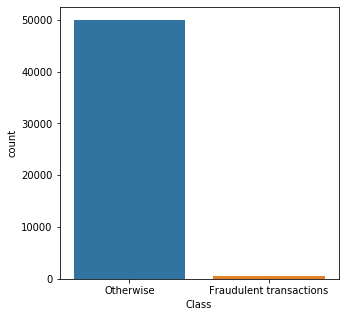

In [10]:
plt.figure(figsize=(5,5))
g = sns.countplot(cc.Class)
g.set_xticklabels(['Otherwise', 'Fraudulent transactions'])

Il dataset continua ad essere fortemente sbilanciato.

In [11]:
# normalizzo la colonna amount 
cc['normAmount'] = StandardScaler().fit_transform(np.array(cc['Amount']).reshape(-1, 1)) 
  
# elimino le colonne Amount
cc = cc.drop('Amount', axis = 1) 

Divito il dataset in training e test set:

In [12]:
X_train, X_test, y_train, y_test =\
train_test_split(cc.drop('Class', axis=1), cc.Class, test_size=0.3, random_state=seed)

Alleno una SVM con kernel gaussiano (non è stata effettuata una GridSearchCV poiché richiederebbe tempo).

In [13]:
svm = SVC(kernel='rbf', gamma='auto', C=100, random_state=seed, probability=True)
svm.fit(X_train, y_train)
print("Accuracy sul training set: %0.2f"%svm.score(X_train,y_train))

Accuracy sul training set: 1.00


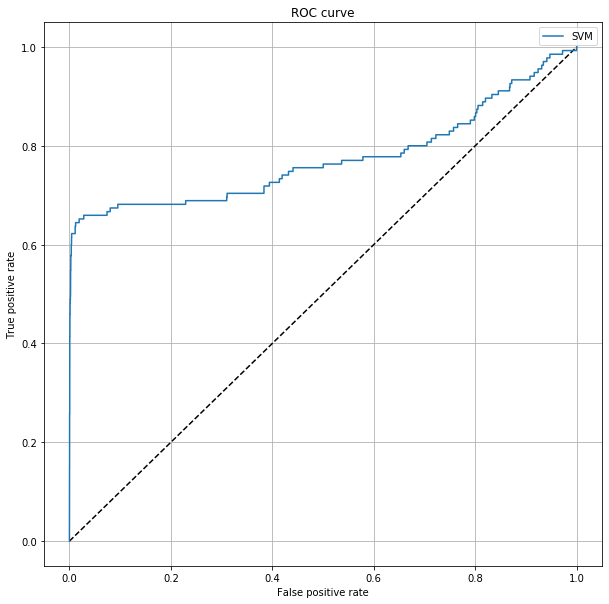

SVM

Error: 0.013538013195586066
MSE: 0.005974305646064619

Confusion Matrix:
[[15004     9]
 [   98    37]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15013
           1       0.80      0.27      0.41       135

    accuracy                           0.99     15148
   macro avg       0.90      0.64      0.70     15148
weighted avg       0.99      0.99      0.99     15148

Accuracy
0.9929363612358068
------------------------------------------------------



In [14]:
y_pred_svm = svm.predict_proba(X_test)[:,1]

fpr_svm, tpr_svm, threshold_svm = roc_curve(y_test, y_pred_svm)

plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid()
plt.show()

print("SVM\n")
print("Error:",mean_absolute_error(y_test, y_pred_svm))
print("MSE:",mean_squared_error(y_test, y_pred_svm))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm.round()))
print("\nClassification Report")
print(classification_report(y_test, y_pred_svm.round()))
print("Accuracy")
print(accuracy_score(y_test, y_pred_svm.round(), normalize=True))
print("------------------------------------------------------\n")

Il risultato è buono, ma come si può notare il Recall score non è ottimale.

### 17.1 Undersampling

Il metodo di undersampling consiste nel ridurre la classe maggioritaria, conservando solo una parte dei suoi record. Generalmente, alcune osservazioni vengono eliminate in modo casuale dalla classe maggioritaria per bilanciare il numero di record con la classe minoritaria.
Esistono tecniche di undersampling più avanzate, come quelle che selezionano campioni specifici più distanti dal decision boundary. Tali tecniche non hanno portato alcun miglioramento rispetto alla semplice selezione casuale dei campioni.
L'undersampling non è consigliato quando la classe minoritaria è troppo piccola perché riduce fortemente il dataset, con una perdita di informazioni potenzialmente utili, fornendo così al modello pochi dati per il training rendendolo più soggetto a errori.

In [16]:
u_data = cc[cc.Class==1].copy() #creo un dataset con i dati della classe minoritaria

#aggiungo al dataset un numero di record (scelti a caso) della classe maggioritaria pari a quello della classe minoritaria
u_data = u_data.append(cc[cc.Class==0].sample(n=len(cc[cc.Class==1]), random_state=seed).copy()) 

In [17]:
print(u_data.Class.value_counts())

1    492
0    492
Name: Class, dtype: int64


[Text(0, 0, 'Otherwise'), Text(0, 0, 'Fraudulent transactions')]

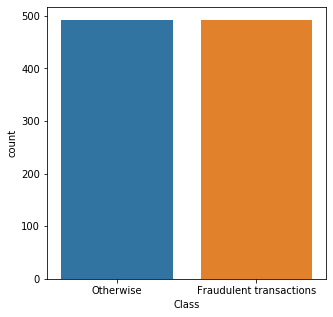

In [18]:
plt.figure(figsize=(5,5))
g = sns.countplot(u_data.Class)
g.set_xticklabels(['Otherwise', 'Fraudulent transactions'])

In [19]:
X_train, X_test, y_train, y_test =\
train_test_split(u_data.drop('Class', axis=1), u_data.Class, test_size=0.3, random_state=seed)

In [20]:
svm = SVC(kernel='rbf', gamma='auto', C=100, random_state=seed, probability=True)
svm.fit(X_train, y_train)
print("Accuracy sul training set: %0.2f"%svm.score(X_train,y_train))

Accuracy sul training set: 0.96


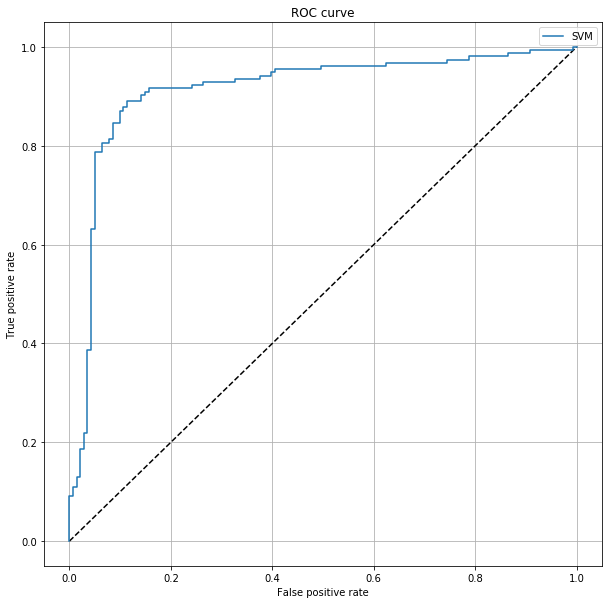

SVM

Error: 0.2608960876074894
MSE: 0.1136918728032105

Confusion Matrix:
[[129  12]
 [ 27 128]]

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       141
           1       0.91      0.83      0.87       155

    accuracy                           0.87       296
   macro avg       0.87      0.87      0.87       296
weighted avg       0.87      0.87      0.87       296

Accuracy
0.8682432432432432
------------------------------------------------------



In [21]:
y_pred_svm = svm.predict_proba(X_test)[:,1]

fpr_svm, tpr_svm, threshold_svm = roc_curve(y_test, y_pred_svm)

plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid()
plt.show()

print("SVM\n")
print("Error:",mean_absolute_error(y_test, y_pred_svm))
print("MSE:",mean_squared_error(y_test, y_pred_svm))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm.round()))
print("\nClassification Report")
print(classification_report(y_test, y_pred_svm.round()))
print("Accuracy")
print(accuracy_score(y_test, y_pred_svm.round(), normalize=True))
print("------------------------------------------------------\n")

Il modello così allenato ha uno score di accuracy minore ma risulta essere nettamente più bilanciato con f1-score più alto. Tuttavia abbiamo escluso una grossa fetta di informazioni e allenato il nostro classificatore con pochi dati.

### 17.1 Oversampling

Il metodo oversampling, invece, viene utilizzato per aumentare la cardinalità della classe minoritaria.
Il modo più semplice per sovracampionare è ricampionare la classe minoritaria duplicando le osservazioni. In questo modo i dati ricampionati sono esattamente gli stessi già presenti nel dataset.

In [46]:
#creo un dataset con tutti i record della classe minoritaria "duplicati" più volte
o_data = cc[cc.Class==1].copy()
for i in range(6):
    o_data = o_data.append(cc[cc.Class==1].copy())

#aggiungo lo stesso numero di record (scelti a caso) della classe maggioritaria    
o_data = o_data.append(cc[cc.Class==0].sample(n=len(o_data[o_data.Class==1]), random_state=seed).copy())

In [47]:
print(o_data.Class.value_counts())

1    3444
0    3444
Name: Class, dtype: int64


[Text(0, 0, 'Otherwise'), Text(0, 0, 'Fraudulent transactions')]

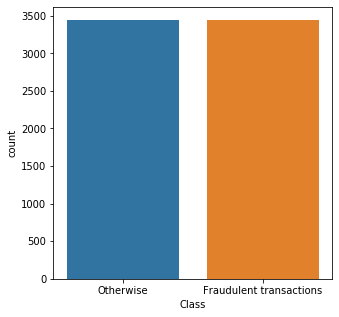

In [48]:
plt.figure(figsize=(5,5))
g = sns.countplot(o_data.Class)
g.set_xticklabels(['Otherwise', 'Fraudulent transactions'])

In [49]:
X_train, X_test, y_train, y_test =\
train_test_split(o_data.drop('Class', axis=1), o_data.Class, test_size=0.3, random_state=seed)

In [50]:
svm = SVC(kernel='rbf', gamma='auto', C=100, random_state=seed, probability=True)
svm.fit(X_train, y_train)
print("Accuracy sul training set: %0.2f"%svm.score(X_train,y_train))

Accuracy sul training set: 0.95


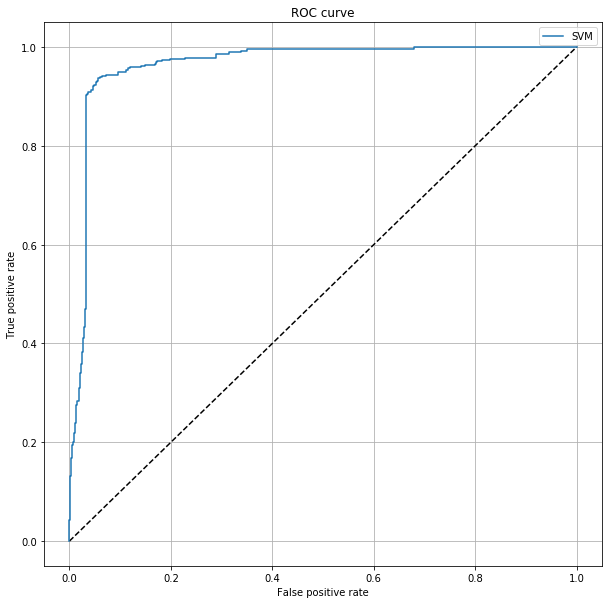

SVM

Error: 0.11837370049194591
MSE: 0.05439436160529073

Confusion Matrix:
[[941  63]
 [ 65 998]]

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1004
           1       0.94      0.94      0.94      1063

    accuracy                           0.94      2067
   macro avg       0.94      0.94      0.94      2067
weighted avg       0.94      0.94      0.94      2067

Accuracy
0.9380745041122399
------------------------------------------------------



In [51]:
y_pred_svm = svm.predict_proba(X_test)[:,1]

fpr_svm, tpr_svm, threshold_svm = roc_curve(y_test, y_pred_svm)

plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid()
plt.show()

print("SVM\n")
print("Error:",mean_absolute_error(y_test, y_pred_svm))
print("MSE:",mean_squared_error(y_test, y_pred_svm))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm.round()))
print("\nClassification Report")
print(classification_report(y_test, y_pred_svm.round()))
print("Accuracy")
print(accuracy_score(y_test, y_pred_svm.round(), normalize=True))
print("------------------------------------------------------\n")

Il training di un modello con un numero troppo alto di dati duplicati può portare a problemi di overfitting: per questo motivo è opportuno sovracampionare il dataset con dati sintetici.

#### 17.1.2 Oversampling con dati sintetici (SMOTE)

Il sovracampionamento mediante la generazione di dati è utile a bilanciare il dataset attraverso la generazione di nuove osservazioni "sintetiche" (basate su quelle di minoranza).
Esistono diversi metodi per l'oversampling attraverso dati sintetici. Una delle tecniche più comuni è chiamata SMOTE (Synthetic Minority Over-sampling Technique). L'algoritmo in questione osserva lo spazio delle features dei campioni della classe minoritaria e considera i k punti più vicini (k-nearest neighbors) per crearne di nuovi e aumentare la cardinalità della classe stessa.
SMOTE e altri algoritmi di oversampling (come ADASYN) sono inclusi nella libreria <i>imbalanced-learn</i> che può essere installata digitando `conda install -c conda-forge imbalanced-learn` nel prompt di Anconda.

<img src="smote.png" width="500">

In [53]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [54]:
#per semplificare le operazioni selezione un numero ancora più ristretto di record
s_cc = cc[cc.Class==1].copy() #creo un dataset con tutti i dati della classe 1
s_cc= s_cc.append(cc[cc.Class==0].sample(n=3000, random_state=seed).copy()) #aggiungo 3000 record per la classe 0

Bilancio il dataset tramite SMOTE:

In [55]:
X_resampled, y_resampled = SMOTE(k_neighbors=5, random_state=seed).fit_resample(s_cc.drop('Class', axis=1), s_cc.Class)
print(sorted(Counter(y_resampled).items()))

[(0, 3000), (1, 3000)]


C:\Users\visig\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


L'algoritmo ha bilanciato le due classi generando nuove osservazioni per la classe minoritaria. Adesso le due classi hanno pari cardinalità.

In [56]:
X_train, X_test, y_train, y_test =\
train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=seed)

In [57]:
svm = SVC(kernel='rbf', gamma='auto', C=100, random_state=seed, probability=True)
svm.fit(X_train, y_train)
print("Accuracy sul training set: %0.2f"%svm.score(X_train,y_train))

Accuracy sul training set: 0.95


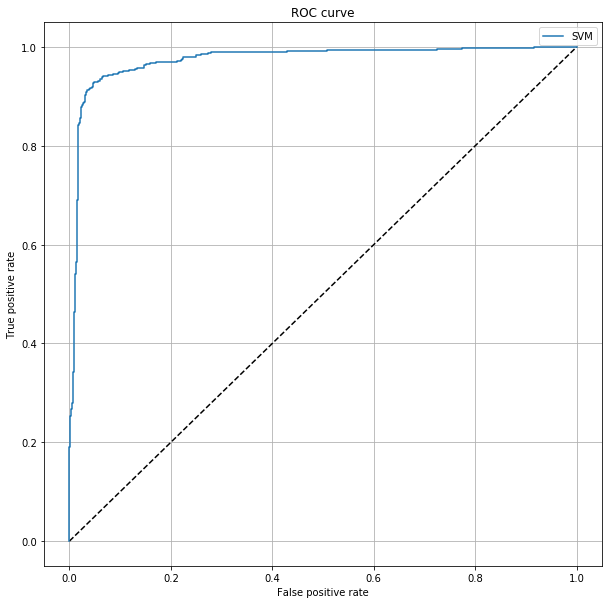

SVM

Error: 0.12022036580327591
MSE: 0.05154865700139597

Confusion Matrix:
[[848  44]
 [ 65 843]]

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       892
           1       0.95      0.93      0.94       908

    accuracy                           0.94      1800
   macro avg       0.94      0.94      0.94      1800
weighted avg       0.94      0.94      0.94      1800

Accuracy
0.9394444444444444
------------------------------------------------------



In [58]:
y_pred_svm = svm.predict_proba(X_test)[:,1]

fpr_svm, tpr_svm, threshold_svm = roc_curve(y_test, y_pred_svm)

plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid()
plt.show()

print("SVM\n")
print("Error:",mean_absolute_error(y_test, y_pred_svm))
print("MSE:",mean_squared_error(y_test, y_pred_svm))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm.round()))
print("\nClassification Report")
print(classification_report(y_test, y_pred_svm.round()))
print("Accuracy")
print(accuracy_score(y_test, y_pred_svm.round(), normalize=True))
print("------------------------------------------------------\n")

In [94]:
#verifico quanti record "doppioni" ha generato l'algoritmo
data_resampled = pd.DataFrame(data= X_resampled, columns=s_cc.drop('Class', axis=1).columns)
data_resampled['Class']=y_resampled
print('Numero di record dupplicati:',\
      len(data_resampled[data_resampled.Class==1])-len(data_resampled[data_resampled.Class==1].drop_duplicates()))

Numero di record dupplicati: 78
